### Email Model: propensity to interact with email in next 30 days

### Loading data through spark table

In [12]:
sd_model_build = spark.sql("""
select 
customer_id
,total_delivered_90d
,max_open_dt_90d
,max_click_dt_90d
,unique_opens_90d
,unique_clicks_90d
,total_delivered_30d
,max_open_dt_30d
,max_click_dt_30d
,unique_opens_30d
,unique_clicks_30d
,total_delivered_7d
,max_open_dt_7d
,max_click_dt_7d
,unique_opens_7d
,unique_clicks_7d
,pv_count_7_days
,pv_count_30_days
,pv_count_90_days
,atc_count_7_days
,atc_count_30_days
,atc_count_90_days
,search_counts_7d 
,search_counts_30d 
,search_counts_90d 
,homepage_counts_7d
,homepage_counts_30d
,homepage_counts_90d
,frequency
,recency
,monetary
,app_frequency
,app_recency
,app_monetary
,email_status_flag as label
,mktng_mail_opt_out_flag

from table_1
where customer_id is not null

""")

#### basic checks

In [7]:
spark.sql("""select 
max(unique_opens_90d) as a, 
max(unique_clicks_90d) as b, 
max(unique_opens_30d) as c
, max(unique_clicks_30d) as d
, max(unique_opens_7d) as e
, max(unique_clicks_7d) as f
from table_1""").toPandas()

,a,b,c,d,e,f
0,1.0,1.0,1.0,1.0,1.0,1.0


In [14]:
## Checking Distribution
spark.sql("""select count(*)
from table_1""").toPandas()

,count(1)
0,12829111


In [15]:
## Checking Distribution
spark.sql("""select count(*)*100/12829111, email_status_flag
from table_1
group by email_status_flag""").toPandas()

"""
0 <- Ignored the mail
1 <- Opened the mail
2 <- Open&Clicked the mail
"""

,(CAST((count(1) * CAST(100 AS BIGINT)) AS DOUBLE) / CAST(12829111 AS DOUBLE)),email_status_flag
0,58.392994,0
1,30.691363,1
2,10.915643,2


In [16]:
## Initialize label indexer to be used in the pipeline later - Stage 1
labelIndexer = StringIndexer(inputCol="label", outputCol="indexedLabel").setHandleInvalid("skip").fit(sd_model_build)

In [17]:
features = [
'customer_id',
'total_delivered_90d',
'max_open_dt_90d',
'max_click_dt_90d',
'unique_opens_90d',
'unique_clicks_90d',
'total_delivered_30d',
'max_open_dt_30d',
'max_click_dt_30d',
'unique_opens_30d',
'unique_clicks_30d',
'total_delivered_7d',
'max_open_dt_7d',
'max_click_dt_7d',
'unique_opens_7d',
'unique_clicks_7d',
'pv_count_7_days',
'pv_count_30_days',
'pv_count_90_days',
'atc_count_7_days',
'atc_count_30_days',
'atc_count_90_days',
'search_counts_7d',
'search_counts_30d',
'search_counts_90d',
'homepage_counts_7d',
'homepage_counts_30d',
'homepage_counts_90d',
'frequency',
'recency',
'monetary',
'app_frequency',
'app_recency',
'app_monetary',
'label',
'mktng_mail_opt_out_flag'

]

In [18]:
## Remove primary keys and other flags that are not needed here - Stage 2
cols_now = list(set(features)-set(['customer_id','label']))#remove indexed label?b
assembler_features = VectorAssembler(inputCols=cols_now, outputCol='features')

In [19]:
## Creating a dataset with features - format needed as an input when using Pipeline
sd_model_build_features_pipe=sd_model_build.select(list(set(features) - set(['customer_id'])))

In [20]:
## Replacing NAs with 0 - need to fix this
sd_model_build = sd_model_build.fillna(0)

In [21]:
## Caching the features and splitting Test and Train
#allData.cache()
trainingData, testData = sd_model_build.randomSplit([0.7,0.3], seed=0)

In [22]:
trainingData.count()

559574

### Training Data

In [23]:
# Train a RandomForest model - Stage 3
rf_multiclass_mv = RandomForestClassifier(labelCol="indexedLabel", featuresCol="features",numTrees=300, 
        maxDepth=10, minInstancesPerNode=150,
        featureSubsetStrategy="auto")

In [24]:
## Check model object initialized
rf_multiclass_mv

RandomForestClassifier_4dd0b476c1f21e74c083

In [25]:
# Convert indexed labels back to original labels - Stage 4
labelConverter = IndexToString(inputCol="prediction", outputCol="predictedLabel",
                                   labels=labelIndexer.labels)

In [26]:
# Putting indexers and model in a Pipeline - Check all stages here
pipeline = Pipeline(stages=[labelIndexer, assembler_features, rf_multiclass_mv, labelConverter])

### Feature Imp

In [17]:
# Putting indexer and assembler features
pipeline1 = Pipeline(stages=[labelIndexer, assembler_features])
allData1 = pipeline1.fit(trainingData).transform(trainingData)

In [ ]:
# Fitting the model
fit_classifier = rf_multiclass_mv.fit(allData1)
feature_imp_df_class= pd.DataFrame()

In [ ]:
# Creating the features df
feature_df = cols_now
feature_df = pd.DataFrame()
feature_df['feature']=cols_now
feature_df.reset_index(inplace=True)
feature_df['index'] = feature_df.index

In [ ]:
#Getting the feature importance
feature_imp_df_class['importance'] = list(fit_classifier.featureImportances)
feature_imp_df_class.reset_index(inplace=True)
feature_imp_df_class['index'] = feature_imp_df_class.index

class_feature_imp = pd.merge(feature_imp_df_class,feature_df,on='index',how='inner')
class_feature_imp = class_feature_imp.sort_values('importance', ascending=False)
class_feature_imp

In [ ]:
# Saving it as csv
class_feature_imp.to_csv('fea_imp.csv', index=False)

### Training the model

In [27]:
## Pipelining the features - to be fed to RF model
allData = pipeline.fit(trainingData)
trained_model = allData.transform(trainingData)

In [28]:
# Checking the entries in trained model
trained_model.head(1)

[Row(customer_id=28051, total_delivered_90d=41, max_open_dt_90d=1, max_click_dt_90d=13, unique_opens_90d=0.7073170731707317, unique_clicks_90d=0.024390243902439025, total_delivered_30d=14, max_open_dt_30d=1, max_click_dt_30d=143, unique_opens_30d=0.14285714285714285, unique_clicks_30d=0.0, total_delivered_7d=4, max_open_dt_7d=1, max_click_dt_7d=143, unique_opens_7d=0.25, unique_clicks_7d=0.0, pv_count_7_days=0, pv_count_30_days=0, pv_count_90_days=0, atc_count_7_days=0, atc_count_30_days=0, atc_count_90_days=0, search_counts_7d=0, search_counts_30d=0, search_counts_90d=0, homepage_counts_7d=0, homepage_counts_30d=0, homepage_counts_90d=0, frequency=0, recency=0, monetary=0.0, app_frequency=0, app_recency=0, app_monetary=0.0, label=u'1', mktng_mail_opt_out_flag=0, indexedLabel=0.0, features=SparseVector(34, {1: 0.0244, 2: 1.0, 9: 0.25, 12: 0.7073, 14: 1.0, 17: 41.0, 18: 143.0, 19: 143.0, 23: 4.0, 25: 13.0, 27: 14.0, 28: 0.1429, 30: 1.0}), rawPrediction=DenseVector([207.2717, 56.0757, 36

In [29]:
#Distribution for each label for trained data
mapping_train=trained_model.select('label','indexedLabel')
mapping_train=mapping_train.toPandas()
mapping_train_df=mapping_train.groupby(['label','indexedLabel']).size().reset_index().rename(columns={0:'count'})
mapping_train_df['distribution']=mapping_train_df['count']*100/sum(mapping_train_df['count'])
mapping_train_df

,label,indexedLabel,count,distribution
0,0,2.0,69325,12.388889
1,1,0.0,329423,58.870319
2,2,1.0,160826,28.740792


In [30]:
# Select (prediction, true label) and compute test error
evaluator = MulticlassClassificationEvaluator(
    labelCol="indexedLabel", predictionCol="prediction", metricName="accuracy")
accuracy_train = evaluator.evaluate(trained_model)
#print("Train Error = %g" % (1.0 - accuracy_train))

In [31]:
# Select (prediction, true label) and compute weighted precision
evaluator = MulticlassClassificationEvaluator(
    labelCol="indexedLabel", predictionCol="prediction", metricName="weightedPrecision")
wp_train = evaluator.evaluate(trained_model)
#print("weighted Precision = %g" % wp_train)

In [32]:
# Select (prediction, true label) and compute weighted recall
evaluator = MulticlassClassificationEvaluator(
    labelCol="indexedLabel", predictionCol="prediction", metricName="weightedRecall")
recall_train = evaluator.evaluate(trained_model)
#print("weighted recall = %g" % recall_train)

In [33]:
# Overall diagnostics - accuracy, weighted Precision, Weighted Recall(for trained data)
print("Accuracy = %g" % accuracy_train)
print("Train Error = %g" % (1.0 - accuracy_train))
print("weighted Precision = %g" % wp_train) 
print("weighted recall = %g" % recall_train)

Accuracy = 0.748536
Train Error = 0.251464
weighted Precision = 0.640681
weighted recall = 0.648536


## Predicting on test data

In [34]:
# Prediction on test data
predictions = allData.transform(testData)

In [35]:
predictions.head()

Row(customer_id=22402, total_delivered_90d=35, max_open_dt_90d=1, max_click_dt_90d=8, unique_opens_90d=0.8, unique_clicks_90d=0.02857142857142857, total_delivered_30d=12, max_open_dt_30d=1, max_click_dt_30d=143, unique_opens_30d=0.8333333333333334, unique_clicks_30d=0.0, total_delivered_7d=3, max_open_dt_7d=1, max_click_dt_7d=143, unique_opens_7d=1.0, unique_clicks_7d=0.0, pv_count_7_days=0, pv_count_30_days=0, pv_count_90_days=0, atc_count_7_days=0, atc_count_30_days=0, atc_count_90_days=0, search_counts_7d=0, search_counts_30d=0, search_counts_90d=0, homepage_counts_7d=0, homepage_counts_30d=0, homepage_counts_90d=0, frequency=0, recency=0, monetary=0.0, app_frequency=0, app_recency=0, app_monetary=0.0, label=u'2', mktng_mail_opt_out_flag=0, indexedLabel=1.0, features=SparseVector(34, {1: 0.0286, 2: 1.0, 9: 1.0, 12: 0.8, 14: 1.0, 17: 35.0, 18: 143.0, 19: 143.0, 23: 3.0, 25: 8.0, 27: 12.0, 28: 0.8333, 30: 1.0}), rawPrediction=DenseVector([239.2746, 51.0395, 9.6858]), probability=Dense

In [36]:
# Select (prediction, true label) and compute test error
evaluator = MulticlassClassificationEvaluator(
    labelCol="indexedLabel", predictionCol="prediction", metricName="accuracy")
accuracy_train = evaluator.evaluate(predictions)
print("Train Error = %g" % (1.0 - accuracy_train))

Train Error = 0.351984


In [37]:
# Select (prediction, true label) and compute weighted precision
evaluator = MulticlassClassificationEvaluator(
    labelCol="indexedLabel", predictionCol="prediction", metricName="weightedPrecision")
wp_train = evaluator.evaluate(predictions)
print("weighted Precision = %g" % wp_train)

weighted Precision = 0.639972


In [38]:
# Select (prediction, true label) and compute weighted recall
evaluator = MulticlassClassificationEvaluator(
    labelCol="indexedLabel", predictionCol="prediction", metricName="weightedRecall")
recall_train = evaluator.evaluate(predictions)
print("weighted recall = %g" % recall_train)

weighted recall = 0.648016


In [39]:
# Overall diagnostics - accuracy, weighted Precision, Weighted Recall(for trained data)
print("Accuracy = %g" % accuracy_train)
print("Train Error = %g" % (1.0 - accuracy_train))
print("weighted Precision = %g" % wp_train) 
print("weighted recall = %g" % recall_train)

Accuracy = 0.748016
Train Error = 0.251984
weighted Precision = 0.639972
weighted recall = 0.648016


### Percentile plots over propensity to interact- predicted and actuals

In [113]:
query = """
with base as 
(
select customer_id, {mv}, {mv}_prb, ntile(100) over (order by {mv}_prb) as prop_decile
from table_3
)
select prop_decile, count(customer_id) as cust_cnt, mean({mv}_prb) as avg_prop, mean({mv}) as avg_actual
from base 
group by prop_decile
order by prop_decile
"""

Ignored

with base as 
(
select customer_id, Ignored, Ignored_prob, ntile(100) over (order by Ignored_prob desc) as prop_decile
from vn000b4.actual_preds_multiclass_email_test
)
select prop_decile, count(customer_id) as cust_cnt, avg(Ignored_prob) as avg_prop, avg(Ignored) as avg_actual
from base 
group by prop_decile
order by prop_decile

Open_n_Click

with base as 
(
select customer_id, Open_n_Click, Open_n_Click_prob, ntile(100) over (order by Open_n_Click_prob desc) as prop_decile
from vn000b4.actual_preds_multiclass_email_test
)
select prop_decile, count(customer_id) as cust_cnt, avg(Open_n_Click_prob) as avg_prop, avg(Open_n_Click) as avg_actual
from base 
group by prop_decile
order by prop_decile

Open

with base as 
(
select customer_id, Open, Open_prob, ntile(100) over (order by Open_prob desc) as prop_decile
from vn000b4.actual_preds_multiclass_email_test
)
select prop_decile, count(customer_id) as cust_cnt, avg(Open_prob) as avg_prop, avg(Open) as avg_actual
from base 
group

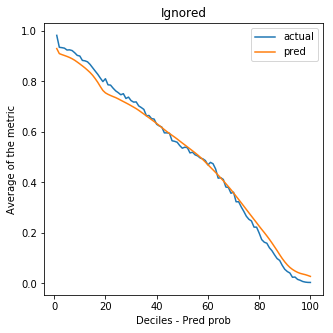

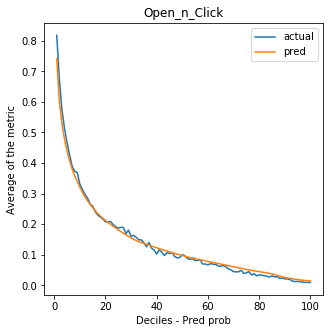

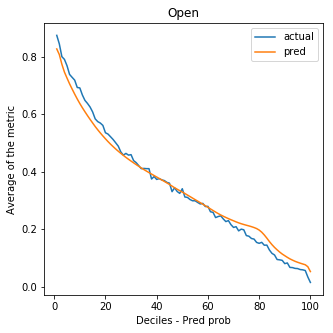

In [55]:
import pylab
for mv in mv_list:
    print(mv)
    query_final = query.format(mv=mv)
    print(query_final)
    df = spark.sql(query_final)
    dataframe = df.toPandas()
    deciles=dataframe['prop_decile'].tolist()
    values_act=dataframe['avg_actual'].tolist()
    values_pred=dataframe['avg_prop'].tolist()
    plt.figure(figsize=(5,5))
    plt.plot(deciles,values_act,label='actual')
    plt.plot(deciles,values_pred,label='pred')
    plt.xlabel("Deciles - Pred prob")
    plt.ylabel("Average of the metric")
    plt.title(mv)
    plt.legend()
    pylab.savefig(str(os.getcwd())+'/test_plots/'+mv+'.png')

In [40]:
predictions_df = predictions.toPandas()

### Confusion matrix

In [41]:
pred_tot_cnt=predictions_df['customer_id'].count()
pred_tot_cnt

240426

In [42]:
# creating list for prediction label
y_pred=predictions_df['prediction']

In [43]:
#checking for max indexed label
y_pred.max()

2.0

In [44]:
# creating list for indexed label
y_actual=predictions_df['indexedLabel']

In [45]:
# creating confusion matrix
df_confusion = pd.crosstab(y_actual, y_pred)

## Calculating Recall and Precision

In [49]:
# Calculating True Predictions
TP = np.diag(crosstab)
TP

array([127621,  17827,  10352])

In [50]:
# False possitive
FP = np.sum(crosstab, axis=0) - TP
FP 

prediction
0.0    66760
1.0    10447
2.0     7419
dtype: int64

In [51]:
# False negative
FN = np.sum(crosstab, axis=1) - TP
FN

indexedLabel
0.0    14172
1.0    51272
2.0    19182
dtype: int64

In [52]:
# True negative
num_classes = 2
TN = []
crosstab =crosstab.values
for i in range(num_classes):
    temp = np.delete(crosstab, i, 0)    # delete ith row
    temp = np.delete(temp, i, 1)  # delete ith column
    TN.append(sum(sum(temp)))
TN 

[31873, 160880]

In [53]:
# sum of all(TP,FP,FN,TN) should be equal to total base count
for i in range(num_classes):
    print(TP[i] + FP[i] + FN[i] + TN[i] == pred_tot_cnt)

True
True


In [54]:
# Calculating precision for each label
precision = TP/(TP+FP)
precision_pd=pd.DataFrame(precision)
precision_pd.columns= ['precision']
precision_pd

,precision
prediction,
0.0,0.656551
1.0,0.630509
2.0,0.582522


In [55]:
# Calculating recall for each label
recall = TP/(TP+FN)
recall_pd=pd.DataFrame(recall)
recall_pd.columns= ['recall']
recall_pd


,recall
indexedLabel,
0.0,0.900051
1.0,0.257992
2.0,0.350511


In [56]:
import pandas as pd
Precision_recall_matrix=precision_pd.join(recall_pd)
Precision_recall_matrix 

,precision,recall
prediction,,
0.0,0.656551,0.900051
1.0,0.630509,0.257992
2.0,0.582522,0.350511
